### Problem Statement:

**The proliferation of social media enables people to express their opinions widely online. However, at the same time, this has resulted in the emergence of conflict and hate, making online environments uninviting for users. Although researchers have found that hate is a problem across multiple platforms, there is a lack of models for online hate detection.**

**Online hate, described as abusive language, aggression, cyberbullying, hatefulness and many others has been identified as a major threat on online social media platforms. Social media platforms are the most prominent grounds for such toxic behaviour.**

**There has been a remarkable increase in the cases of cyberbullying and trolls on various social media platforms. Many celebrities and influences are facing backlashes from people and have to come across hateful and offensive comments. This can take a toll on anyone and affect them mentally leading to depression, mental illness, self-hatred and suicidal thoughts.**

**Internet comments are bastions of hatred and vitriol. While online anonymity has provided a new outlet for aggression and hate speech, machine learning can be used to fight it. The problem we sought to solve was the tagging of internet comments that are aggressive towards other users. This means that insults to third parties such as celebrities will be tagged as unoffensive, but “u are an idiot” is clearly offensive.**

**Our goal is to build a prototype of online hate and abuse comment classifier which can used to classify hate and offensive comments so that it can be controlled and restricted from spreading hatred and cyberbullying.** 

    

### Importing Required Library

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import klib as kl
import nltk
import re
from nltk.corpus import stopwords
from imblearn.over_sampling import SMOTE
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, plot_roc_curve, accuracy_score, confusion_matrix
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### Reading Train Data

In [5]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving test.csv to test.csv
User uploaded file "test.csv" with length 60354593 bytes


In [4]:
df = pd.read_csv('/content/sample_data/train.csv')
df.head()

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


### Data Set Description

The data set contains the training set, which has approximately 1,59,000 samples and the test set which contains nearly 1,53,000 samples. All the data samples contain 8 fields which includes ‘Id’, ‘Comments’, ‘Malignant’, ‘Highly malignant’, ‘Rude’, ‘Threat’, ‘Abuse’ and ‘Loathe’. 
The label can be either 0 or 1, where 0 denotes a NO while 1 denotes a YES. There are various comments which have multiple labels. The first attribute is a unique ID associated with each comment.   
The data set includes:

 - **Malignant:** It is the Label column, which includes values 0 and 1, denoting if the comment is          malignant or not. 
 
 -	**Highly Malignant:** It denotes comments that are highly malignant and hurtful. 
 
 -	**Rude:** It denotes comments that are very rude and offensive.
 
 -	**Threat:** It contains indication of the comments that are giving any threat to someone. 
 
 -	**Abuse:** It is for comments that are abusive in nature. 
 
 -	**Loathe:** It describes the comments which are hateful and loathing in nature.
 
 -	**ID:** It includes unique Ids associated with each comment text given.   
 
 -	**Comment text:** This column contains the comments extracted from various social media platforms.


### Check no of row and column

In [ ]:
print('No of Rows and Columns ----->', df.shape )

No of Rows and Columns -----> (159571, 8)


### Checking for Null values

In [ ]:
print('================================\n')
print(df.isnull().sum())
print('\n================================')


id                  0
comment_text        0
malignant           0
highly_malignant    0
rude                0
threat              0
abuse               0
loathe              0
dtype: int64



#### There is no null value

### Information about dataset

In [ ]:
print('==================================================\n')
print(df.info())
print('====================================================')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   id                159571 non-null  object
 1   comment_text      159571 non-null  object
 2   malignant         159571 non-null  int64 
 3   highly_malignant  159571 non-null  int64 
 4   rude              159571 non-null  int64 
 5   threat            159571 non-null  int64 
 6   abuse             159571 non-null  int64 
 7   loathe            159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB
None


#### Categorical data present in our data set

### Analysis of Data

In [ ]:
df[df['malignant'] ==1][df.columns[0:3]]

,id,comment_text,malignant
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
12,0005c987bdfc9d4b,Hey... what is it..\n@ | talk .\nWhat is it......,1
16,0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming ...",1
42,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1
43,00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1
...,...,...,...
159494,fef4cf7ba0012866,"""\n\n our previous conversation \n\nyou fuckin...",1
159514,ff39a2895fc3b40e,YOU ARE A MISCHIEVIOUS PUBIC HAIR,1
159541,ffa33d3122b599d6,Your absurd edits \n\nYour absurd edits on gre...,1
159546,ffb47123b2d82762,"""\n\nHey listen don't you ever!!!! Delete my e...",1


In [ ]:
df['id'][df['highly_malignant'] ==1]

6         0002bcb3da6cb337
55        0020e7119b96eeeb
181       006e87872c8b370c
442       01208d2b76624130
579       018663f910e0bfe6
                ...       
159096    f871b05d4caa6f20
159099    f885a3e2d779342e
159281    fb726deec64157bd
159312    fbf20e312cd4a78d
159400    fd052883fa6a8697
Name: id, Length: 1595, dtype: object

In [ ]:
df['id'][df['rude'] ==1]

6         0002bcb3da6cb337
42        001810bf8c45bf5f
43        00190820581d90ce
51        001dc38a83d420cf
55        0020e7119b96eeeb
                ...       
159411    fd2f53aafe8eefcc
159493    fef142420a215b90
159494    fef4cf7ba0012866
159541    ffa33d3122b599d6
159554    ffbdbb0483ed0841
Name: id, Length: 8449, dtype: object

In [ ]:
df['id'][df['threat'] ==1]

79        003217c3eb469ba9
176       006b94add72ed61c
600       0199d6af27b715f3
802       02230885017a50c5
1017      02c6e41e4b317ac3
                ...       
157718    e26b106943e02cbf
158717    f264b7fb9a4b4f53
158856    f4dca9e513e0366f
159029    f780e4f42aa5a344
159400    fd052883fa6a8697
Name: id, Length: 478, dtype: object

In [ ]:
df['id'][df['abuse'] ==1]

6         0002bcb3da6cb337
42        001810bf8c45bf5f
43        00190820581d90ce
55        0020e7119b96eeeb
56        0020fd96ed3b8c8b
                ...       
159494    fef4cf7ba0012866
159514    ff39a2895fc3b40e
159541    ffa33d3122b599d6
159546    ffb47123b2d82762
159554    ffbdbb0483ed0841
Name: id, Length: 7877, dtype: object

In [ ]:
df['id'][df['loathe'] ==1]

42        001810bf8c45bf5f
105       00472b8e2d38d1ea
176       006b94add72ed61c
218       008e0818dde894fb
238       0097dd5c29bf7a15
                ...       
159281    fb726deec64157bd
159336    fc3efa2f6f025f6d
159400    fd052883fa6a8697
159449    fdce660ddcd6d7ca
159494    fef4cf7ba0012866
Name: id, Length: 1405, dtype: object

#### These are the id which malignant comment are written. 

### Drop unwanted column

In [5]:
col = ['id','highly_malignant','rude','threat','abuse','loathe']
df = df.drop(columns=col,axis=1)
df.head()

,comment_text,malignant
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


### Calculating total count of each category comments

In [ ]:
counts = []
categories = list(df.columns.values)
for i in categories:
    counts.append((i, df[i].sum()))
df_stats = pd.DataFrame(counts, columns=['Category', 'Count'])
df_stats

,Category,Count
0,malignant,15294
1,highly_malignant,1595
2,rude,8449
3,threat,478
4,abuse,7877
5,loathe,1405


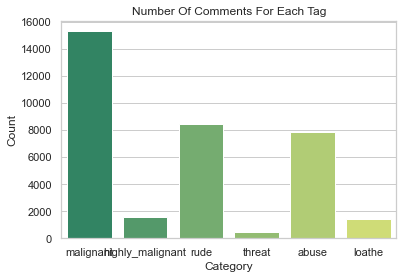

In [ ]:
sns.set(style="whitegrid")
sns.barplot(x='Category', y='Count', data=df_stats, palette="summer",)
plt.title("Number Of Comments For Each Tag")
plt.show()

#### This shows that the number of malignant comments is high

### Corelation of Feature vs Label using Heat map

In [ ]:
kl.corr_mat(df) # returns a color-encoded correlation matrix

,malignant,highly_malignant,rude,threat,abuse,loathe
malignant,1.00,0.31,0.68,0.16,0.65,0.27
highly_malignant,0.31,1.00,0.40,0.12,0.38,0.20
rude,0.68,0.40,1.00,0.14,0.74,0.29
threat,0.16,0.12,0.14,1.00,0.15,0.12
abuse,0.65,0.38,0.74,0.15,1.00,0.34
loathe,0.27,0.20,0.29,0.12,0.34,1.00


-----------
Heat Map :-
-----------


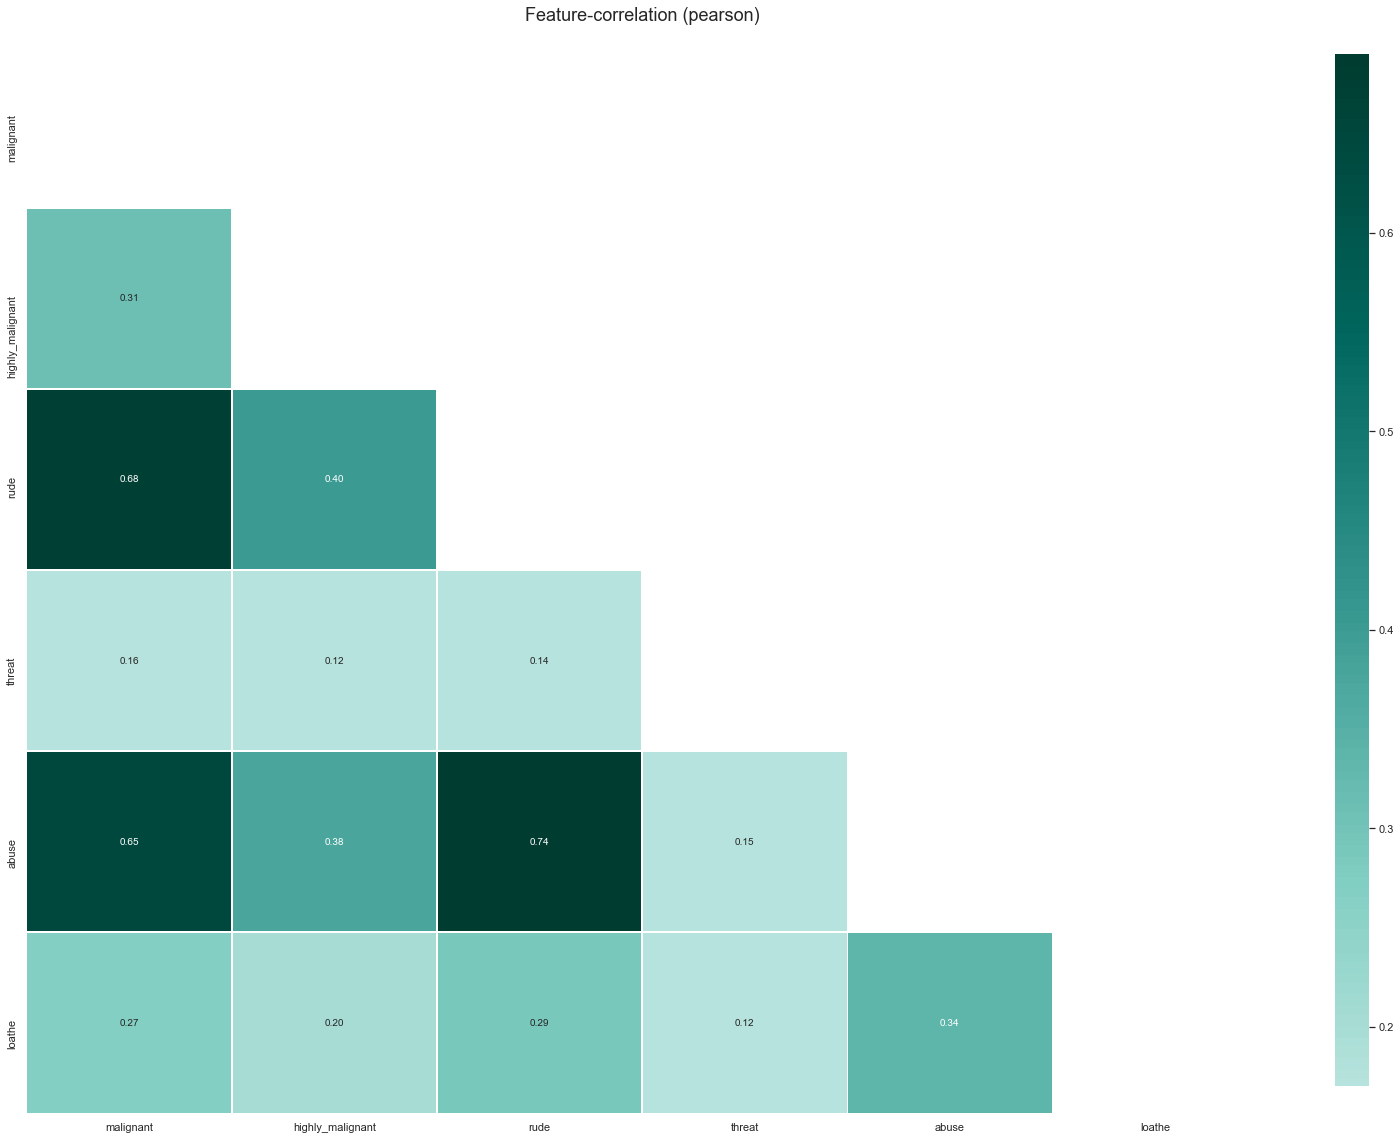

In [ ]:
print('-----------')
print('Heat Map :-')
print('-----------')
kl.corr_plot(df, figsize = (22, 16)) # returns a color-encoded heatmap, ideal for correlations
plt.tight_layout()

#### Rude column is highly related to label

### Data Cleaning

In [6]:
import sys
sys.setrecursionlimit(5000)

In [9]:
ps = PorterStemmer()
corpus = []
for i in range(0, len(df)):
    comment = re.sub('[^a-zA-Z]',' ', df['comment_text'][i])
    comment = comment.lower()
    comment = comment.split()
    
    comment = [ps.stem(word) for word in comment if word not in stopwords.words('english')]
    comment = ' '. join(comment)
    corpus.append(comment)

In [7]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Creating Bag of Words

In [10]:
cv = CountVectorizer(max_features = 5000)
x = cv.fit_transform(corpus).toarray()[:5000]

In [11]:
x

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

### Spliting Dataset into features and label

In [16]:
y = df['malignant'][:5000]
print('Data has been splited')

Data has been splited


### Checking Classs Imblance

In [17]:
y.value_counts()

0    4497
1     503
Name: malignant, dtype: int64

#### Class are not balance

### Handling Class Imbalance

In [18]:
SM = SMOTE()
x_over, y_over = SM.fit_resample(x,y)
print('---------------------')
print('Class are balanced :-')
print('---------------------')
print(y_over.value_counts())
print('---------------------')

---------------------
Class are balanced :-
---------------------
1    4497
0    4497
Name: malignant, dtype: int64
---------------------


### Data Scaling

In [19]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)
x_scaled

array([[-0.02829559, -0.02804755, -0.020004  , ..., -0.04652608,
        -0.03679443, -0.03466182],
       [-0.02829559, -0.02804755, -0.020004  , ..., -0.04652608,
        -0.03679443, -0.03466182],
       [-0.02829559, -0.02804755, -0.020004  , ..., -0.04652608,
        -0.03679443, -0.03466182],
       ...,
       [-0.02829559, -0.02804755, -0.020004  , ..., -0.04652608,
        -0.03679443, -0.03466182],
       [-0.02829559, -0.02804755, -0.020004  , ..., -0.04652608,
        -0.03679443, -0.03466182],
       [-0.02829559, -0.02804755, -0.020004  , ..., -0.04652608,
        -0.03679443, -0.03466182]])

#### Data has been scaled

### Split data into train and test. Model will be bulit on training data and tested on test data

In [20]:
x_train, x_test, y_train, y_test = train_test_split(x_over, y_over, test_size = 0.25, random_state = 355)
print('Data has been splited.')

Data has been splited.


## Model Bulding

### Naive Baye model instantiaing, training and evaluating

In [25]:
nb = MultinomialNB().fit(x_train, y_train)
y_pred = nb.predict(x_test)

In [26]:
print('-----------------------------------------------------------\n')
print('Confusion Matrix :')
print( confusion_matrix(y_test, y_pred))
print('\n----------------------------------------------------------')
print('\nClassification Report:')
print(classification_report(y_test, y_pred, digits = 2))
print('------------------------------------------------------------')

-----------------------------------------------------------

Confusion Matrix :
[[1062   28]
 [ 482  677]]

----------------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.97      0.81      1090
           1       0.96      0.58      0.73      1159

    accuracy                           0.77      2249
   macro avg       0.82      0.78      0.77      2249
weighted avg       0.83      0.77      0.77      2249

------------------------------------------------------------


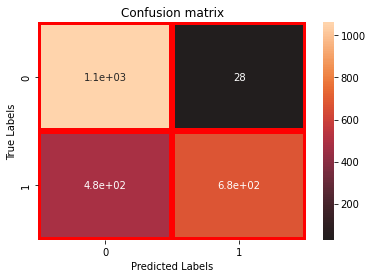

In [27]:
# plot confusion matrix heatmap

conf_mat = confusion_matrix(y_test,y_pred)

ax=plt.subplot()

sns.heatmap(conf_mat,annot=True,ax=ax,linewidths=5,linecolor='r',center=0)

ax.set_xlabel('Predicted Labels');ax.set_ylabel('True Labels')

ax.set_title('Confusion matrix')
plt.show()

#### Conclusion : Naive Baye model has 77% score

### Cross Validation score to check if the model is overfitting

In [28]:
cv = cross_val_score(nb, x, y, cv = 5)
print('Cross Validation score of Naive Baye model --->', cv.mean())

Cross Validation score of Naive Baye model ---> 0.9380000000000001


#### Conclusion : Naive Baye model has 93% Cross Validation score

### Naive Baye Hyperparameter Tuning

In [30]:
grid_param = {'alpha':[0.05,0.1,0.2,0.3,1],'fit_prior':['True','False']}

In [31]:
grid_search = GridSearchCV(estimator = nb, param_grid = grid_param, cv = 3 , n_jobs = -1)

In [32]:
grid_search.fit(x_train, y_train)

GridSearchCV(cv=3, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0.05, 0.1, 0.2, 0.3, 1],
                         'fit_prior': ['True', 'False']})

In [33]:
best_parameters = grid_search.best_params_
print(best_parameters)

{'alpha': 0.2, 'fit_prior': 'True'}


In [34]:
hnb = MultinomialNB(alpha = 0.2, fit_prior = True)
hnb.fit(x_train, y_train)
hnb.score(x_test, y_test)

0.7785682525566918

In [35]:
print('-----------------------------------------------------------\n')
print('Confusion Matrix :')
print( confusion_matrix(y_test, y_pred))
print('\n----------------------------------------------------------')
print('\nClassification Report:')
print(classification_report(y_test, y_pred, digits = 2))
print('------------------------------------------------------------')

-----------------------------------------------------------

Confusion Matrix :
[[1062   28]
 [ 482  677]]

----------------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.97      0.81      1090
           1       0.96      0.58      0.73      1159

    accuracy                           0.77      2249
   macro avg       0.82      0.78      0.77      2249
weighted avg       0.83      0.77      0.77      2249

------------------------------------------------------------


#### After Hyperparameter Tuning model accuracy score 77%.

### Saving The Model

In [36]:
# saving the model to the Local file system
filename = 'MALIGNANT.pickle'
pickle.dump(hnb, open(filename, 'wb'))

### Reading Test Data

In [4]:
df2 = pd.read_csv("/content/sample_data/test.csv")
df2.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


### Check no of row and column

In [ ]:
print('No of Rows and columns --------->', df2.shape)

No of Rows and columns ---------> (153164, 2)


### Checking for Null values

In [ ]:
print('================================\n')
print(df.isnull().sum())
print('\n================================')


malignant           0
highly_malignant    0
rude                0
threat              0
abuse               0
loathe              0
dtype: int64



### Drop unwanted column

In [5]:
df2 = df2.drop('id', axis = 1)
df2.head(2)

,comment_text
0,Yo bitch Ja Rule is more succesful then you'll...
1,== From RfC == \n\n The title is fine as it is...


### Download Pickel File

In [13]:
from google.colab import files
files.download('MALIGNANT.pickle')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Data Cleaning and Preprocessing

In [7]:
ps = PorterStemmer()
corpus = []
for i in range(0, len(df2)):
    comment = re.sub('[^a-zA-Z]',' ', df2['comment_text'][i])
    comment = comment.lower()
    comment = comment.split()
    
    comment = [ps.stem(word) for word in comment if not word in stopwords.words('english')]
    comment = ' '. join(comment)
    corpus.append(comment)

### Creating Bag of Words

In [8]:
cv = CountVectorizer(max_features = 5000)
x = cv.fit_transform(corpus).toarray()[:5000]

### Data Scaling

In [9]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)
x_scaled

array([[-1.89770821e-02,  0.00000000e+00,  0.00000000e+00, ...,
        -1.41435500e-02, -2.31001716e-02, -1.41435500e-02],
       [-1.89770821e-02,  0.00000000e+00,  0.00000000e+00, ...,
        -1.41435500e-02, -2.31001716e-02, -1.41435500e-02],
       [-1.89770821e-02,  0.00000000e+00,  0.00000000e+00, ...,
        -1.41435500e-02, -2.31001716e-02, -1.41435500e-02],
       ...,
       [ 3.16094932e+01,  0.00000000e+00,  0.00000000e+00, ...,
        -1.41435500e-02, -2.31001716e-02, -1.41435500e-02],
       [-1.89770821e-02,  0.00000000e+00,  0.00000000e+00, ...,
        -1.41435500e-02, -2.31001716e-02, -1.41435500e-02],
       [-1.89770821e-02,  0.00000000e+00,  0.00000000e+00, ...,
        -1.41435500e-02, -2.31001716e-02, -1.41435500e-02]])

#### Data has been scaled

### Predict Malighant Comments

In [11]:
model = pickle.load(open('/content/MALIGNANT.pickle', 'rb'))

In [12]:
Prediction = pd.DataFrame([model.predict(x_scaled)], index = ['Predicted'])
Prediction

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,4960,4961,4962,4963,4964,4965,4966,4967,4968,4969,4970,4971,4972,4973,4974,4975,4976,4977,4978,4979,4980,4981,4982,4983,4984,4985,4986,4987,4988,4989,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
Predicted,0,1,1,1,1,1,1,1,1,1,1,0,1,0,1,1,1,1,0,1,1,1,1,0,0,0,1,1,1,0,1,1,0,1,1,1,1,1,0,0,...,1,0,0,0,1,0,1,1,1,1,1,0,1,1,1,0,0,1,1,1,1,0,1,1,1,0,1,0,1,1,0,1,1,1,1,1,1,0,0,1


## Final Conclusion: Naive Baye is best our model.